In [5]:
from scipy.io import wavfile
import os

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import tensorflow as tf

In [6]:
##### file system
INPUT_DIR = "/kaggle/input/audio-mnist/data"
WORKING_DIR = "/kaggle/working"
NEW_INPUT_DIR = WORKING_DIR + "/input"
NEW_INPUT_AUDIO_DIR = NEW_INPUT_DIR + "/audio"
NEW_INPUT_SPECTROGRAM_DIR = NEW_INPUT_DIR + "/spectrogram"

# dataset
SAMPLE_RATE = 48_000
INPUT_SIZE = 65_536

# training
BATCH_SIZE = 256
# buffer size should be multiple of batch size
# for perfect shuffling, buffer size > data size
# data size = 30_000
BUFFER_SIZE = 30_080
EPOCHS = 1000
DATA_PERCENTAGE = 1

In [7]:
if not os.path.exists(WORKING_DIR):
    os.mkdir(WORKING_DIR)
    
if not os.path.exists(NEW_INPUT_DIR):
    os.mkdir(NEW_INPUT_DIR)

if not os.path.exists(NEW_INPUT_AUDIO_DIR):
    os.mkdir(NEW_INPUT_AUDIO_DIR)

if not os.path.exists(NEW_INPUT_SPECTROGRAM_DIR):
    os.mkdir(NEW_INPUT_SPECTROGRAM_DIR)

In [8]:
# set to True to run cells that are only meant for exploration
EXPLORING = False

FIRST_RUN = (not os.path.exists(NEW_INPUT_DIR)) or (len(os.listdir(NEW_INPUT_DIR)) < 3)

# Handle Given Data

Starting by checking how the data is stored

In [9]:
if EXPLORING:
    # each folder in INPUT_DIR is a different voice
    # read the first item of the first folder
    # and print the sample rate and the number of samples and the samples
    for folder in os.listdir(INPUT_DIR):
        sample_rate, samples = wavfile.read(os.path.join(INPUT_DIR, folder, os.listdir(os.path.join(INPUT_DIR, folder))[0]))
        print(f"Sample rate: {sample_rate}")
        print(f"Number of samples: {len(samples)}")
        print(f"Samples: {samples}")
        break

Check if the length of the sound is the same for every one of them

In [10]:
if EXPLORING:
    # check if the number of samples is the same for the 5 files
    pre_number_samples = None
    times = 0
    for folder in os.listdir(INPUT_DIR):
        # for each folder
        for file in os.listdir(os.path.join(INPUT_DIR, folder)):
            _, samples = wavfile.read(os.path.join(INPUT_DIR, folder, file))
            num_samples = len(samples)
            if pre_number_samples is None:
                pre_number_samples = num_samples
            else:
                if pre_number_samples != num_samples:
                    print(f"Number of samples is not the same for all files in {folder}")
                    break

            print(f"Sample rate: {num_samples}")
            times += 1
            if times == 5:
                break
        break


it is not!

Let us check how it is distributed

100%|██████████| 61/61 [01:50<00:00,  1.82s/it]


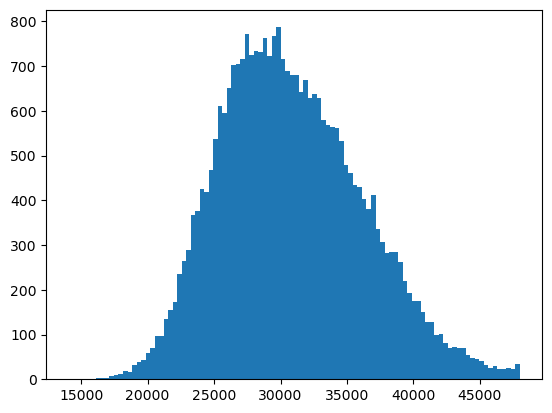

In [11]:
if FIRST_RUN:
    # given that the number of samples is not the same for all files, let's see
    # the distribution of the number of samples
    number_samples = []
    for folder in tqdm(os.listdir(INPUT_DIR)):
        # check if folder is a folder
        if not os.path.isdir(os.path.join(INPUT_DIR, folder)):
            continue
        for file in os.listdir(os.path.join(INPUT_DIR, folder)):
            _, samples = wavfile.read(os.path.join(INPUT_DIR, folder, file))
            number_samples.append(len(samples))

    plt.hist(number_samples, bins=100)

Mean is around 30 000. Setting the size to 65_536 is good for the network, as seen afterwards and is above the max, no audio will be loss.

In [12]:
if EXPLORING:
    max_number_samples = max(number_samples)
    print(f"Max number of samples: {max_number_samples}")

So that the input is the same size for all instances, we pad them by stretching the last and first elmeent, centering the initial sound.

We are also storing these new sounds is a slightly different way. Each folder corresponds to a class, not to a speaker.

In [13]:
def create_same_size_raw_audios():
    # let's pad the samples
    for folder in tqdm(os.listdir(INPUT_DIR)):
        # check if "folder" is a folder
        if not os.path.isdir(os.path.join(INPUT_DIR, folder)):
            continue
        for file in os.listdir(os.path.join(INPUT_DIR, folder)):
            sample_rate, samples = wavfile.read(
                os.path.join(INPUT_DIR, folder, file))
            if len(samples) < INPUT_SIZE:
                # pad the samples on both sides
                samples = np.pad(samples, ((INPUT_SIZE - len(samples) + 1) //
                                 2, (INPUT_SIZE - len(samples)) // 2), mode='edge')

            # get the label
            label = file.split("_")[0]
            # creating the label folder if it does not exist
            if not os.path.exists(os.path.join(NEW_INPUT_AUDIO_DIR, label)):
                os.mkdir(os.path.join(NEW_INPUT_AUDIO_DIR, label))

            wavfile.write(os.path.join(NEW_INPUT_AUDIO_DIR, label,
                          file), sample_rate, samples)
            
def create_spectrograms():
    for folder in tqdm(os.listdir(INPUT_DIR)):
        # check if "folder" is a folder
        if not os.path.isdir(os.path.join(INPUT_DIR, folder)):
            continue
        for file in os.listdir(os.path.join(INPUT_DIR, folder)):
            sample_rate, samples = wavfile.read(
                os.path.join(INPUT_DIR, folder, file))

            if len(samples) < INPUT_SIZE:
                # pad the samples on both sides
                samples = np.pad(samples, ((INPUT_SIZE - len(samples) + 1) //
                                 2, (INPUT_SIZE - len(samples)) // 2), mode='edge')
                
            # pass samples to float
            samples = tf.cast(samples, tf.float32)

            # get the label
            label = file.split("_")[0]
            # creating the label folder if it does not exist
            if not os.path.exists(os.path.join(NEW_INPUT_SPECTROGRAM_DIR, label)):
                os.mkdir(os.path.join(NEW_INPUT_SPECTROGRAM_DIR, label))
                
            # create the spectrogram
            spectrogram = tf.signal.stft(samples, frame_length=255, frame_step=128)
            spectrogram = tf.abs(spectrogram)
            
            # save the spectrogram
            np.save(os.path.join(NEW_INPUT_SPECTROGRAM_DIR, label, file), spectrogram.numpy())


if FIRST_RUN:    
    create_same_size_raw_audios()

100%|██████████| 61/61 [00:34<00:00,  1.79it/s]


In case one wants to reset the development, run the following cell.

In [14]:
if False:
    import shutil
    shutil.rmtree(NEW_INPUT_DIR)

Let us show an example of these new samples.

In [15]:
if EXPLORING:
    sample_rate, samples = wavfile.read(os.path.join(NEW_INPUT_DIR, "3", os.listdir(os.path.join(NEW_INPUT_DIR, "3"))[0]))
    plt.plot(samples)

# Handle New Data

In this section we will deal with this new data.

One cannot simply load them into an array because it would take too much memory.

A data pipeline is required: inspiration: https://www.tensorflow.org/guide/data

## Consuming Sets of Files

Our files are separated into folders, each folder contains its class.
We read the files according to the path.

In [17]:
import pathlib

audios_root = pathlib.Path(NEW_INPUT_AUDIO_DIR)

list_ds = tf.data.Dataset.list_files(str(audios_root/'*/*'))

def process_path(file_path):
  label = tf.strings.split(file_path, os.sep)[-2]
  return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

## Normalization

We normalize the data to values between -1 and 1, taking into account that the samples are in 16 bits. so the range is -32768 to 32767.

After normalization, a new sample is showed.

(65536, 1)


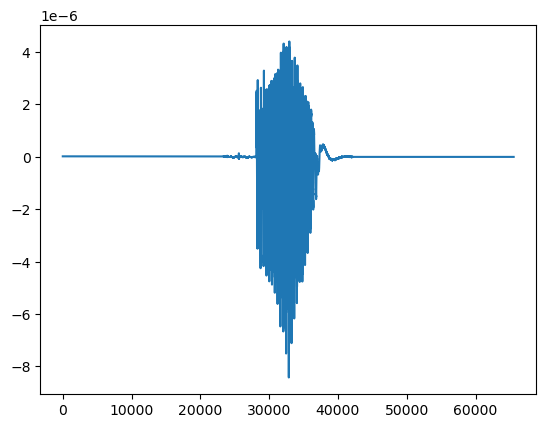

In [18]:
def normalize(samples):
    return samples / 32768

normalized_ds = labeled_ds.map(lambda x, y: (normalize(tf.audio.decode_wav(x, desired_channels=1).audio), y))

for audio, label in normalized_ds.take(1):
    print(audio.shape)
    plt.plot(audio.numpy())

In [19]:
# batch and shuffle the dataset
batch_ds = normalized_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [35]:
class GAN:
    # constants
    MODEL_NAME = "GAN"

    # constructor
    def __init__(self, fake_input_shape=(100,), real_input_shape=(INPUT_SIZE, 1)):
        # constants

        # parameters
        self._fake_input_shape = fake_input_shape
        self._real_input_shape = real_input_shape

        # models
        self._generator = self._make_generator_model(self._fake_input_shape)
        self._discriminator = self._make_discriminator_model(
            self._real_input_shape)

        self._generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self._discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

        self._checkpoint = False

    def get_generator(self):
        return self._generator

    def get_discriminator(self):
        return self._discriminator

    def train(self, dataset, epochs):
        # restore from the latest checkpoint
        if self._checkpoint:
            self._checkpoint.restore(
                tf.train.latest_checkpoint(CHECKPOINT_DIR))

        # run the epochs
        for epoch in tqdm(range(epochs)):
            print("Epoch {}/{}".format(epoch+1, epochs))

            # run the batches
            for audios in tqdm(dataset):
                self._train_step(audios)

            # generate, save, and display one sample
            self._generate_sample(save=True)

            # save the checkpoint
            if self._checkpoint:
                if (epoch + 1) % self._checkpoint.save_each == 0:
                    self._checkpoint.save(file_prefix=self._checkpoint.prefix)

    def set_checkpoint(self, save_each=15):
        self._checkpoint.prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
        self._checkpoint.object = tf.train.Checkpoint(
            generator_optimizer=self._generator_optimizer,
            discriminator_optimizer=self._discriminator_optimizer,
            generator=self._generator,
            discriminator=self._discriminator
        )
        self._checkpoint.save_each = save_each

    def _generate_sample(self, save=False, experiment_name="default", epoch=0):
        single_seed = tf.random.normal([1, self._fake_input_shape[0]])
        generated_audio = self._generator(single_seed, training=False)
        # desnormalize the audio
        generated_audio = (generated_audio * 32768).numpy().astype(np.int16)

        if save:
            # create the folder if it doesnt exist
            folder_name = "{}/{}/{}".format(WORKING_DIR, self.MODEL_NAME, experiment_name)
            # create all folders recursively
            os.makedirs(folder_name, exist_ok=True)

            # save the audio
            wavfile.write("{}/epoch_{}.wav".format(folder_name, epoch), SAMPLE_RATE, generated_audio[0])
            
        # display the audio
        plt.plot(generated_audio[0])
        plt.show()

    @tf.function
    def _train_step(self, audios):
        noise = tf.random.normal([BATCH_SIZE, self._fake_input_shape[0]])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_audios = self._generator(noise, training=True)

            real_output = self._discriminator(audios, training=True)
            fake_output = self._discriminator(generated_audios, training=True)

            gen_loss = self._generator_loss(fake_output)
            disc_loss = self._discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(
            gen_loss, self._generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(
            disc_loss, self._discriminator.trainable_variables)

        self._generator_optimizer.apply_gradients(
            zip(gradients_of_generator, self._generator.trainable_variables))
        self._discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self._discriminator.trainable_variables))

    def _generator_loss(self, fake_output):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

    def _discriminator_loss(self, real_output, fake_output):
        real_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True)(tf.ones_like(real_output), real_output)
        fake_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True)(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def _make_generator_model(self, input_shape=(100,)):
        # the end goal of the generator is to take an input of a given shape
        # and output a sample of the same shape as the X[0]
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(
            256, use_bias=False, input_shape=input_shape))

        # reshape
        model.add(tf.keras.layers.Reshape((16, 16)))
        model.add(tf.keras.layers.ReLU())

        # transposed convolution
        model.add(tf.keras.layers.Conv1DTranspose(
            32, 25, strides=4, padding='same'))
        model.add(tf.keras.layers.ReLU())

        # transposed convolution
        model.add(tf.keras.layers.Conv1DTranspose(
            16, 25, strides=4, padding='same'))
        model.add(tf.keras.layers.ReLU())

        # transposed convolution
        model.add(tf.keras.layers.Conv1DTranspose(
            8, 25, strides=4, padding='same'))
        model.add(tf.keras.layers.ReLU())

        # transposed convolution
        model.add(tf.keras.layers.Conv1DTranspose(
            4, 25, strides=4, padding='same'))
        model.add(tf.keras.layers.ReLU())

        # transposed convolution
        model.add(tf.keras.layers.Conv1DTranspose(
            2, 25, strides=4, padding='same'))
        model.add(tf.keras.layers.ReLU())

        # transposed convolution
        model.add(tf.keras.layers.Conv1DTranspose(
            1, 25, strides=4, padding='same'))
        model.add(tf.keras.layers.Activation('tanh'))

        return model

    def _make_discriminator_model(self, input_shape=(INPUT_SIZE, 1)):
        model = tf.keras.Sequential()

        # convolution
        model.add(tf.keras.layers.Conv1D(1, 25, strides=4,
                                         input_shape=input_shape, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

        # convolution
        model.add(tf.keras.layers.Conv1D(2, 25, strides=4, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

        # convolution
        model.add(tf.keras.layers.Conv1D(4, 25, strides=4, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

        # convolution
        model.add(tf.keras.layers.Conv1D(8, 25, strides=4, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

        # convolution
        model.add(tf.keras.layers.Conv1D(16, 25, strides=4, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

        # convolution
        model.add(tf.keras.layers.Conv1D(32, 25, strides=4, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

        # reshape
        model.add(tf.keras.layers.Flatten())

        # dense
        model.add(tf.keras.layers.Dense(1))

        return model


In [36]:
gan = GAN()
generator = gan.get_generator()
generator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               25600     
                                                                 
 reshape_4 (Reshape)         (None, 16, 16)            0         
                                                                 
 re_lu_24 (ReLU)             (None, 16, 16)            0         
                                                                 
 conv1d_transpose_24 (Conv1D  (None, 64, 32)           12832     
 Transpose)                                                      
                                                                 
 re_lu_25 (ReLU)             (None, 64, 32)            0         
                                                                 
 conv1d_transpose_25 (Conv1D  (None, 256, 16)          12816     
 Transpose)                                           

In [37]:
discriminator = gan.get_discriminator()
discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 16384, 1)          26        
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 16384, 1)          0         
                                                                 
 conv1d_19 (Conv1D)          (None, 4096, 2)           52        
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 4096, 2)           0         
                                                                 
 conv1d_20 (Conv1D)          (None, 1024, 4)           204       
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 1024, 4)           0         
                                                                 
 conv1d_21 (Conv1D)          (None, 256, 8)           

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000



100%|██████████| 118/118 [04:57<00:00,  2.52s/it]


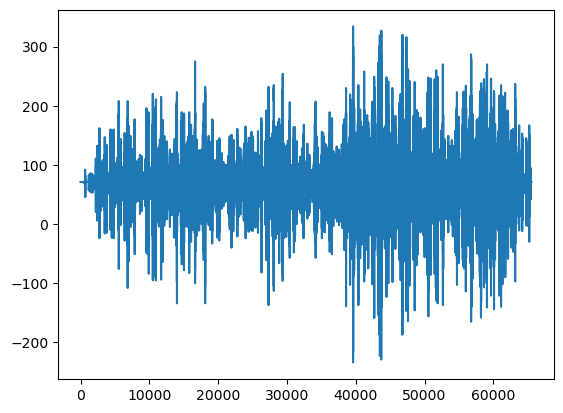

  0%|          | 1/1000 [04:57<82:33:47, 297.52s/it]

Epoch 2/1000



100%|██████████| 118/118 [04:49<00:00,  2.45s/it]


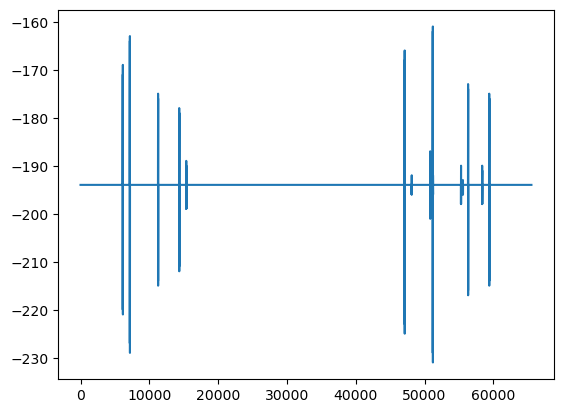

  0%|          | 2/1000 [09:47<81:13:50, 293.02s/it]

Epoch 3/1000



100%|██████████| 118/118 [04:48<00:00,  2.45s/it]


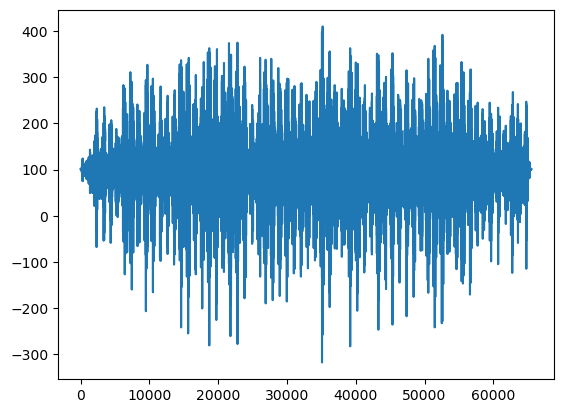

  0%|          | 3/1000 [14:36<80:41:17, 291.35s/it]

Epoch 4/1000



100%|██████████| 118/118 [04:54<00:00,  2.49s/it]


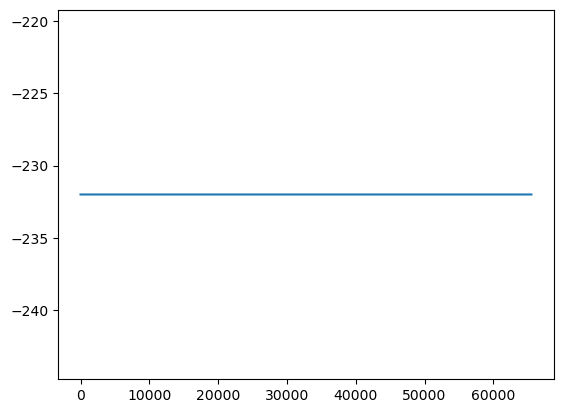

  0%|          | 4/1000 [19:31<80:56:20, 292.55s/it]

Epoch 5/1000



100%|██████████| 118/118 [05:10<00:00,  2.63s/it]


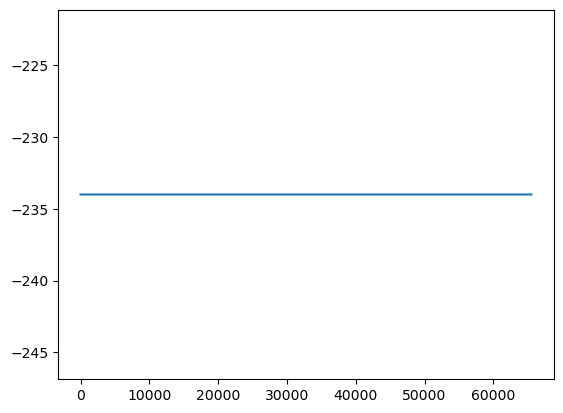

  0%|          | 5/1000 [24:41<82:40:50, 299.15s/it]

Epoch 6/1000



100%|██████████| 118/118 [04:47<00:00,  2.43s/it]


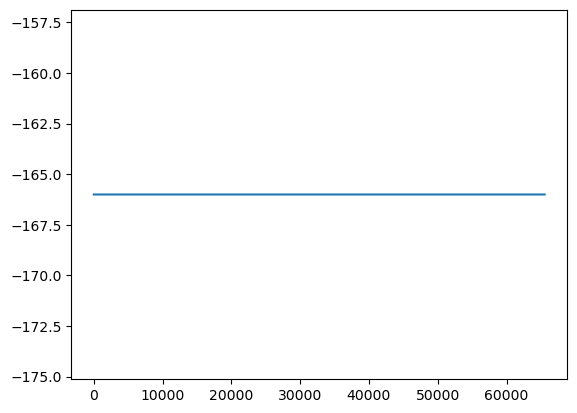

  1%|          | 6/1000 [29:29<81:30:29, 295.20s/it]

Epoch 7/1000



100%|██████████| 118/118 [05:00<00:00,  2.55s/it]


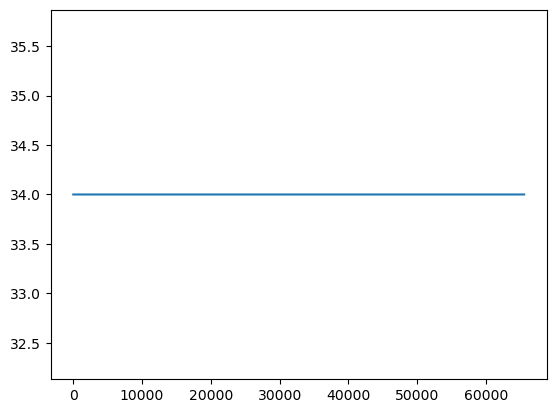

  1%|          | 7/1000 [34:30<81:55:05, 296.98s/it]

Epoch 8/1000



100%|██████████| 118/118 [05:08<00:00,  2.62s/it]


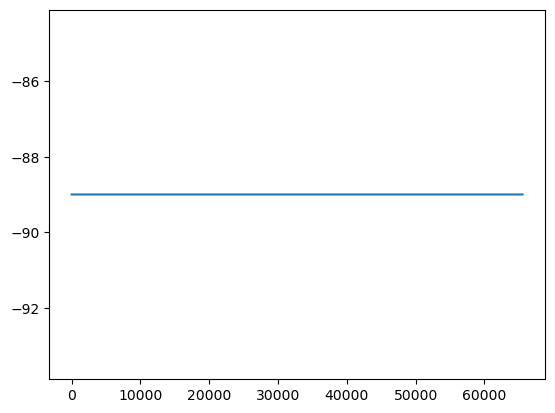

  1%|          | 8/1000 [39:39<82:53:30, 300.82s/it]

Epoch 9/1000



100%|██████████| 118/118 [04:58<00:00,  2.53s/it]


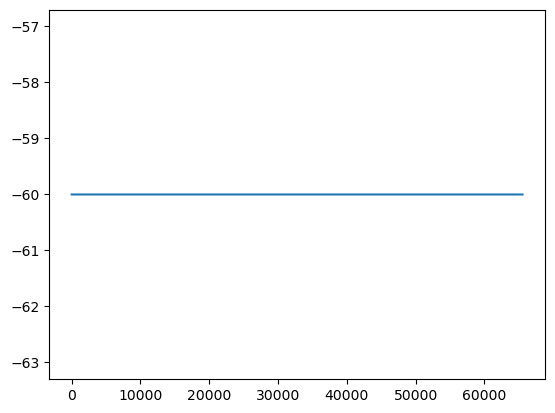

  1%|          | 9/1000 [44:37<82:37:42, 300.16s/it]

Epoch 10/1000



100%|██████████| 118/118 [04:55<00:00,  2.50s/it]


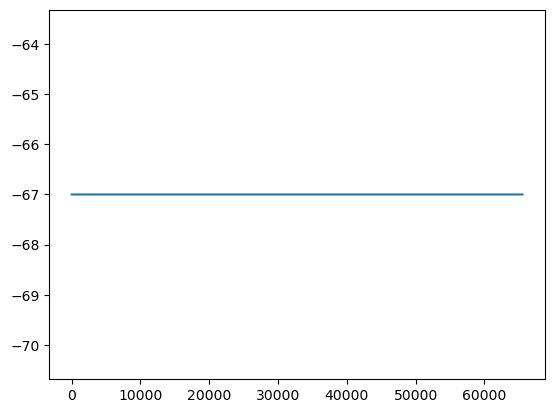

  1%|          | 10/1000 [49:33<82:09:09, 298.74s/it]

Epoch 11/1000



100%|██████████| 118/118 [04:57<00:00,  2.52s/it]


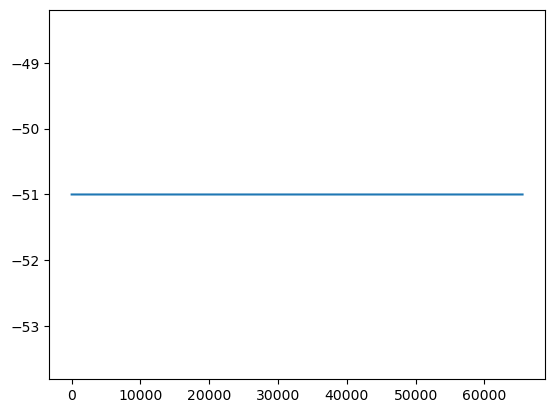

  1%|          | 11/1000 [54:31<81:59:04, 298.43s/it]

Epoch 12/1000



100%|██████████| 118/118 [04:58<00:00,  2.53s/it]


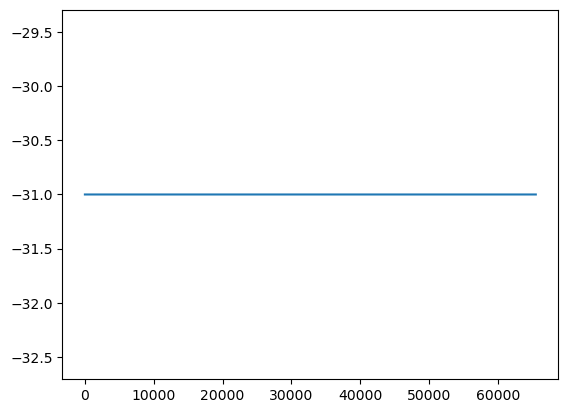

  1%|          | 12/1000 [59:29<81:55:26, 298.51s/it]

Epoch 13/1000



  3%|▎         | 3/118 [00:15<08:00,  4.17s/it]

100%|██████████| 118/118 [04:59<00:00,  2.54s/it]


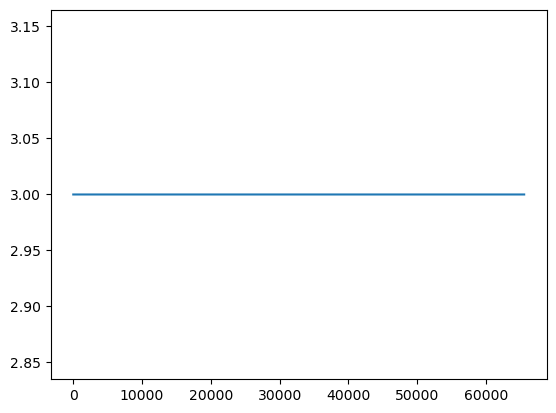

  1%|▏         | 13/1000 [1:04:29<81:56:33, 298.88s/it]

Epoch 14/1000



  1%|          | 1/118 [00:23<46:02, 23.61s/it]

100%|██████████| 118/118 [05:01<00:00,  2.56s/it]


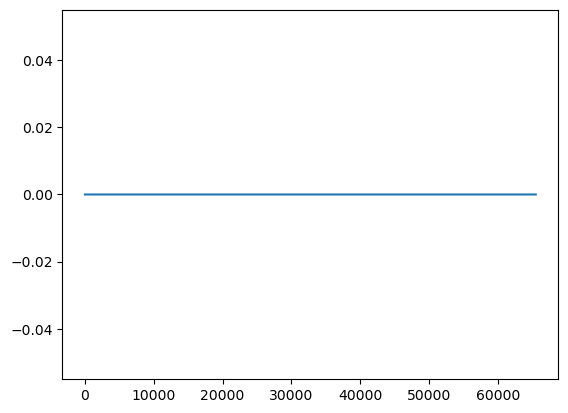

  1%|▏         | 14/1000 [1:09:31<82:06:54, 299.81s/it]

Epoch 15/1000



  4%|▍         | 5/118 [00:20<05:50,  3.10s/it]

100%|██████████| 118/118 [04:57<00:00,  2.52s/it]


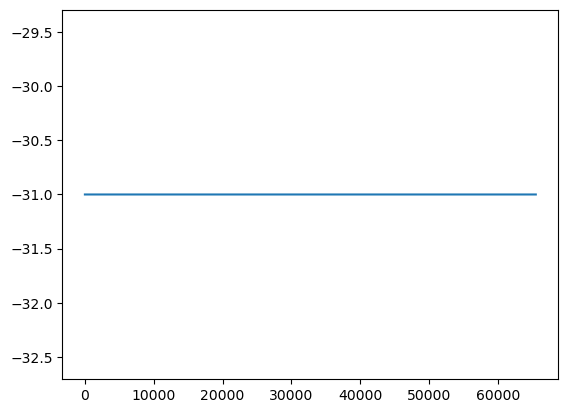

  2%|▏         | 15/1000 [1:14:29<81:50:45, 299.13s/it]

Epoch 16/1000



  8%|▊         | 10/118 [00:42<04:35,  2.56s/it]

100%|██████████| 118/118 [04:58<00:00,  2.53s/it]


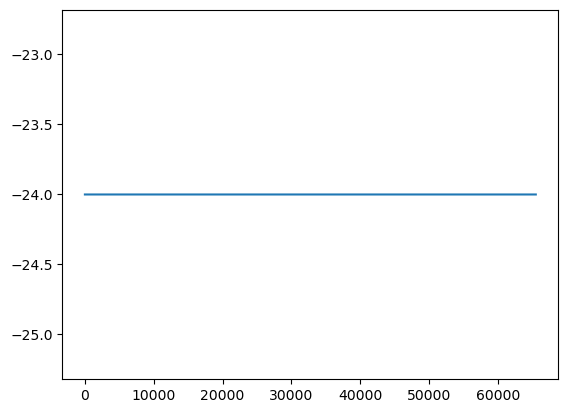

  2%|▏         | 16/1000 [1:19:28<81:45:24, 299.11s/it]

Epoch 17/1000



100%|██████████| 118/118 [04:58<00:00,  2.53s/it]


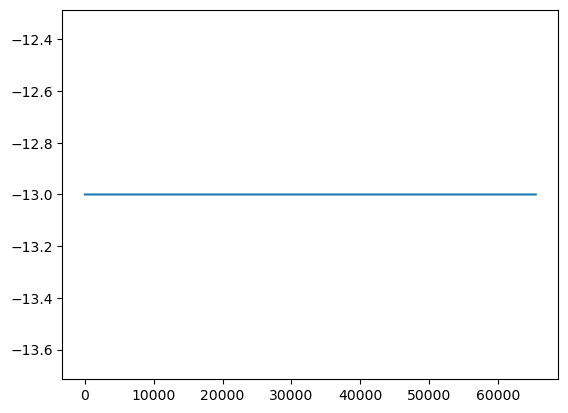

  2%|▏         | 17/1000 [1:24:26<81:36:58, 298.90s/it]

Epoch 18/1000



100%|██████████| 118/118 [04:58<00:00,  2.53s/it]


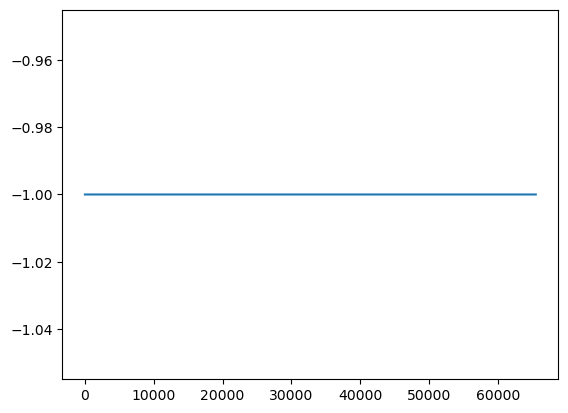

  2%|▏         | 18/1000 [1:29:25<81:30:16, 298.80s/it]

Epoch 19/1000



 27%|██▋       | 32/118 [01:22<03:18,  2.31s/it]

100%|██████████| 118/118 [04:53<00:00,  2.49s/it]


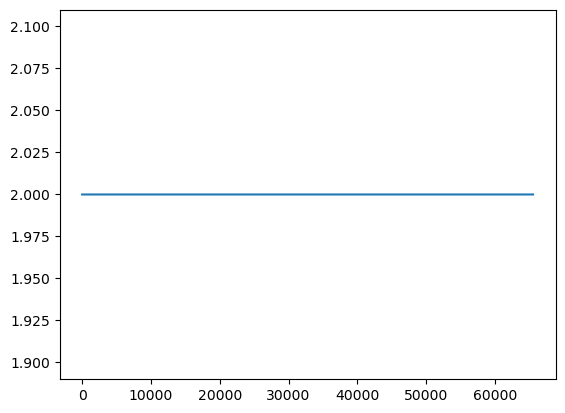

  2%|▏         | 19/1000 [1:34:19<81:01:25, 297.34s/it]

Epoch 20/1000



 31%|███       | 36/118 [01:41<03:09,  2.31s/it]

100%|██████████| 118/118 [04:54<00:00,  2.50s/it]


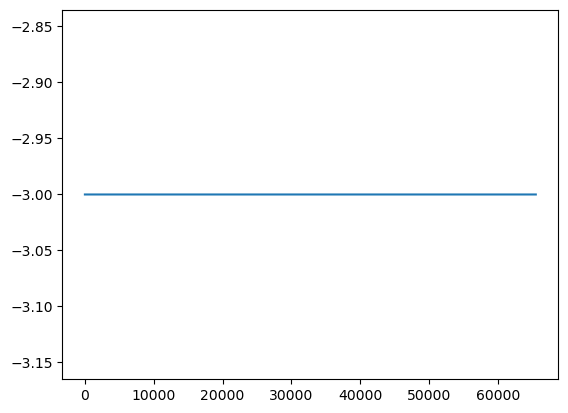

  2%|▏         | 20/1000 [1:39:13<80:43:01, 296.51s/it]

Epoch 21/1000



100%|██████████| 118/118 [04:53<00:00,  2.48s/it]


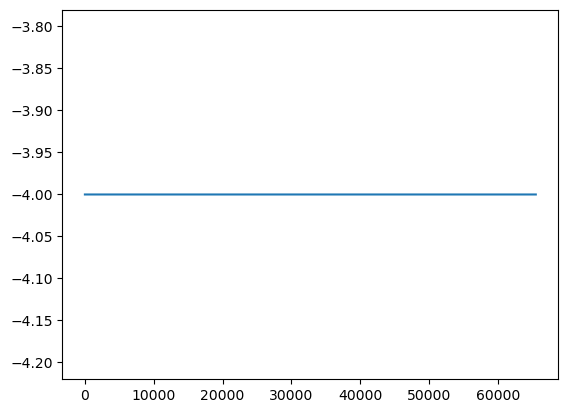

  2%|▏         | 21/1000 [1:44:06<80:21:48, 295.51s/it]

Epoch 22/1000



100%|██████████| 118/118 [04:58<00:00,  2.53s/it]


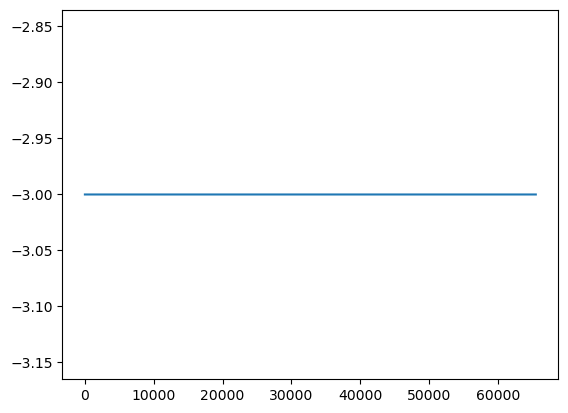

  2%|▏         | 22/1000 [1:49:05<80:34:02, 296.57s/it]

Epoch 23/1000



 27%|██▋       | 32/118 [01:31<03:20,  2.33s/it]

 67%|██████▋   | 79/118 [03:22<01:31,  2.34s/it]

In [ ]:
X = batch_ds.map(lambda x, y: x) # temporary, while we don't need the labels
gan.train(X, EPOCHS)

In [ ]:
# generate all samples in the end with a pyplot plot
predictions = generator(seed, training=False)
predictions = (predictions * 32768).numpy().astype(np.int16)

for i in range(predictions.shape[0]):
    wavfile.write("{}/generated_audio_{}.wav".format(WORKING_DIR, i), SAMPLE_RATE, predictions[i])
    plt.subplot(num_examples_to_generate, 1, i+1)
    plt.plot(predictions[i])